In [2]:
import pandas as pd
import numpy as np
import urllib.request
import zipfile
import random
import itertools
import math

In [3]:
import shapefile
from shapely.geometry import Polygon
from descartes.patch import PolygonPatch
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

In [4]:
from sqlalchemy import create_engine

nyc_database = create_engine('sqlite:///nyc_database.db')

In [5]:
data = pd.read_csv('/home/bashar/Downloads/yellow_tripdata_2017-01.csv')

In [6]:
data.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
0,1,2017-01-09 11:13:28,2017-01-09 11:25:45,1,3.30,1,N,263,161,1,12.5,0.0,0.5,2.00,0.0,0.3,15.30
1,1,2017-01-09 11:32:27,2017-01-09 11:36:01,1,0.90,1,N,186,234,1,5.0,0.0,0.5,1.45,0.0,0.3,7.25
2,1,2017-01-09 11:38:20,2017-01-09 11:42:05,1,1.10,1,N,164,161,1,5.5,0.0,0.5,1.00,0.0,0.3,7.30
3,1,2017-01-09 11:52:13,2017-01-09 11:57:36,1,1.10,1,N,236,75,1,6.0,0.0,0.5,1.70,0.0,0.3,8.50
4,2,2017-01-01 00:00:00,2017-01-01 00:00:00,1,0.02,2,N,249,234,2,52.0,0.0,0.5,0.00,0.0,0.3,52.80


In [7]:

with zipfile.ZipFile("/home/bashar/Downloads/taxi_zones.zip","r") as zip_ref:
    zip_ref.extractall("./shape")

In [8]:
j, chunksize = 1, 100000
for data in pd.read_csv('/home/bashar/Downloads/yellow_tripdata_2017-01.csv', chunksize=chunksize, iterator=True):
        data = data.rename(columns={c: c.replace(' ', '_') for c in data.columns})
        data['pickup_hour'] = [x[11:13] for x in data['tpep_pickup_datetime']]
        data['dropoff_hour'] = [x[11:13] for x in data['tpep_dropoff_datetime']]
        data.index += j
        data.to_sql('table_record', nyc_database, if_exists='append')
        j = data.index[-1] + 1

### Location Data

In [9]:
def get_lat_lon(sf):
    content = []
    for sr in sf.shapeRecords():
        shape = sr.shape
        rec = sr.record
        loc_id = rec[shp_dic['LocationID']]
        
        x = (shape.bbox[0]+shape.bbox[2])/2
        y = (shape.bbox[1]+shape.bbox[3])/2
        
        content.append((loc_id, x, y))
    return pd.DataFrame(content, columns=["LocationID", "longitude", "latitude"])

In [10]:
sf = shapefile.Reader("shape/taxi_zones.shp")
fields_name = [field[0] for field in sf.fields[1:]]
shp_dic = dict(zip(fields_name, list(range(len(fields_name)))))
attributes = sf.records()
shp_attr = [dict(zip(fields_name, attr)) for attr in attributes]

df_loc = pd.DataFrame(shp_attr).join(get_lat_lon(sf).set_index("LocationID"), on="LocationID")
df_loc.head()

,OBJECTID,Shape_Leng,Shape_Area,zone,LocationID,borough,longitude,latitude
0,1,0.116357,0.000782,Newark Airport,1,EWR,9.366817e+05,190522.130278
1,2,0.433470,0.004866,Jamaica Bay,2,Queens,1.033536e+06,161853.982300
2,3,0.084341,0.000314,Allerton/Pelham Gardens,3,Bronx,1.027136e+06,254730.010849
3,4,0.043567,0.000112,Alphabet City,4,Manhattan,9.904240e+05,203100.040432
4,5,0.092146,0.000498,Arden Heights,5,Staten Island,9.321332e+05,139954.541936


In [12]:
def draw_region_map(ax, sf, heat={}):
    continent = [235/256, 151/256, 78/256]
    ocean = (89/256, 171/256, 227/256)    
    
    reg_list={'Staten Island':1, 'Queens':2, 'Bronx':3, 'Manhattan':4, 'EWR':5, 'Brooklyn':6}
    reg_x = {'Staten Island':[], 'Queens':[], 'Bronx':[], 'Manhattan':[], 'EWR':[], 'Brooklyn':[]}
    reg_y = {'Staten Island':[], 'Queens':[], 'Bronx':[], 'Manhattan':[], 'EWR':[], 'Brooklyn':[]}
    
    # colorbar
    if len(heat) != 0:
        norm = mpl.colors.Normalize(vmin=math.sqrt(min(heat.values())), vmax=math.sqrt(max(heat.values()))) #norm = mpl.colors.LogNorm(vmin=1,vmax=max(heat))
        cm=plt.get_cmap('Reds')
        #sm = plt.cm.ScalarMappable(cmap=cm, norm=norm)
        #sm.set_array([])
        #plt.colorbar(sm, ticks=np.linspace(min(heat.values()),max(heat.values()),8), \
        #             boundaries=np.arange(min(heat.values())-10,max(heat.values())+10,.1))
    
    ax.set_facecolor(ocean)
    for sr in sf.shapeRecords():
        shape = sr.shape
        rec = sr.record
        reg_name = rec[shp_dic['borough']]
        
        if len(heat) == 0:
            norm = mpl.colors.Normalize(vmin=1,vmax=6) #norm = mpl.colors.LogNorm(vmin=1,vmax=max(heat))
            cm=plt.get_cmap('Pastel1')
            R,G,B,A = cm(norm(reg_list[reg_name]))
            col = [R,G,B]
        else:
            R,G,B,A = cm(norm(math.sqrt(heat[reg_name])))
            col = [R,G,B]
            
        # check number of parts (could use MultiPolygon class of shapely?)
        nparts = len(shape.parts) # total parts
        if nparts == 1:
            polygon = Polygon(shape.points)
            patch = PolygonPatch(polygon, facecolor=col, alpha=1.0, zorder=2)
            ax.add_patch(patch)
        else: # loop over parts of each shape, plot separately
            for ip in range(nparts): # loop over parts, plot separately
                i0 = shape.parts[ip]
                if ip < nparts-1:
                    i1 = shape.parts[ip+1]-1
                else:
                    i1 = len(shape.points)

                polygon = Polygon(shape.points[i0:i1+1])
                patch = PolygonPatch(polygon, facecolor=col, alpha=1.0, zorder=2)
                ax.add_patch(patch)
                
        reg_x[reg_name].append((shape.bbox[0]+shape.bbox[2])/2)
        reg_y[reg_name].append((shape.bbox[1]+shape.bbox[3])/2)
        
    for k in reg_list:
        if len(heat)==0:
            plt.text(np.mean(reg_x[k]), np.mean(reg_y[k]), k, horizontalalignment='center', verticalalignment='center',
                        bbox=dict(facecolor='black', alpha=0.5), color="white", fontsize=12)     
        else:
            plt.text(np.mean(reg_x[k]), np.mean(reg_y[k]), "{}\n({}K)".format(k, heat[k]/1000), horizontalalignment='center', 
                     verticalalignment='center',bbox=dict(facecolor='black', alpha=0.5), color="white", fontsize=12)       

    # display
    limits = get_boundaries(sf)
    plt.xlim(limits[0], limits[1])
    plt.ylim(limits[2], limits[3])

In [13]:
def draw_zone_map(ax, sf, heat={}, text=[], arrows=[]):
    continent = [235/256, 151/256, 78/256]
    ocean = (89/256, 171/256, 227/256)
    theta = np.linspace(0, 2*np.pi, len(text)+1).tolist()
    ax.set_facecolor(ocean)
    
    # colorbar
    if len(heat) != 0:
        norm = mpl.colors.Normalize(vmin=min(heat.values()),vmax=max(heat.values())) #norm = mpl.colors.LogNorm(vmin=1,vmax=max(heat))
        cm=plt.get_cmap('Reds')
        sm = plt.cm.ScalarMappable(cmap=cm, norm=norm)
        sm.set_array([])
        plt.colorbar(sm, ticks=np.linspace(min(heat.values()),max(heat.values()),8),
                     boundaries=np.arange(min(heat.values())-10,max(heat.values())+10,.1))
    
    for sr in sf.shapeRecords():
        shape = sr.shape
        rec = sr.record
        loc_id = rec[shp_dic['LocationID']]
        zone = rec[shp_dic['zone']]
        
        if len(heat) == 0:
            col = continent
        else:
            if loc_id not in heat:
                R,G,B,A = cm(norm(0))
            else:
                R,G,B,A = cm(norm(heat[loc_id]))
            col = [R,G,B]

        # check number of parts (could use MultiPolygon class of shapely?)
        nparts = len(shape.parts) # total parts
        if nparts == 1:
            polygon = Polygon(shape.points)
            patch = PolygonPatch(polygon, facecolor=col, alpha=1.0, zorder=2)
            ax.add_patch(patch)
        else: # loop over parts of each shape, plot separately
            for ip in range(nparts): # loop over parts, plot separately
                i0 = shape.parts[ip]
                if ip < nparts-1:
                    i1 = shape.parts[ip+1]-1
                else:
                    i1 = len(shape.points)

                polygon = Polygon(shape.points[i0:i1+1])
                patch = PolygonPatch(polygon, facecolor=col, alpha=1.0, zorder=2)
                ax.add_patch(patch)
        
        x = (shape.bbox[0]+shape.bbox[2])/2
        y = (shape.bbox[1]+shape.bbox[3])/2
        if (len(text) == 0 and rec[shp_dic['Shape_Area']] > 0.0001):
            plt.text(x, y, str(loc_id), horizontalalignment='center', verticalalignment='center')            
        elif len(text) != 0 and loc_id in text:
            #plt.text(x+0.01, y-0.01, str(loc_id), fontsize=12, color="white", bbox=dict(facecolor='black', alpha=0.5))
            eta_x = 0.05*np.cos(theta[text.index(loc_id)])
            eta_y = 0.05*np.sin(theta[text.index(loc_id)])
            ax.annotate("[{}] {}".format(loc_id, zone), xy=(x, y), xytext=(x+eta_x, y+eta_y),
                        bbox=dict(facecolor='black', alpha=0.5), color="white", fontsize=12,
                        arrowprops=dict(facecolor='black', width=3, shrink=0.05))
    if len(arrows)!=0:
        for arr in arrows:
            ax.annotate('', xy = arr['dest'], xytext = arr['src'], size = arr['cnt'],
                    arrowprops=dict(arrowstyle="fancy", fc="0.6", ec="none"))
    
    # display
    limits = get_boundaries(sf)
    plt.xlim(limits[0], limits[1])
    plt.ylim(limits[2], limits[3])

In [21]:
def get_boundaries(sf):
    lat, lon = [], []
    for shape in list(sf.iterShapes()):
        lat.extend([shape.bbox[0], shape.bbox[2]])
        lon.extend([shape.bbox[1], shape.bbox[3]])

    margin = 0.01 # buffer to add to the range
    lat_min = min(lat) - margin
    lat_max = max(lat) + margin
    lon_min = min(lon) - margin
    lon_max = max(lon) + margin

    return lat_min, lat_max, lon_min, lon_max

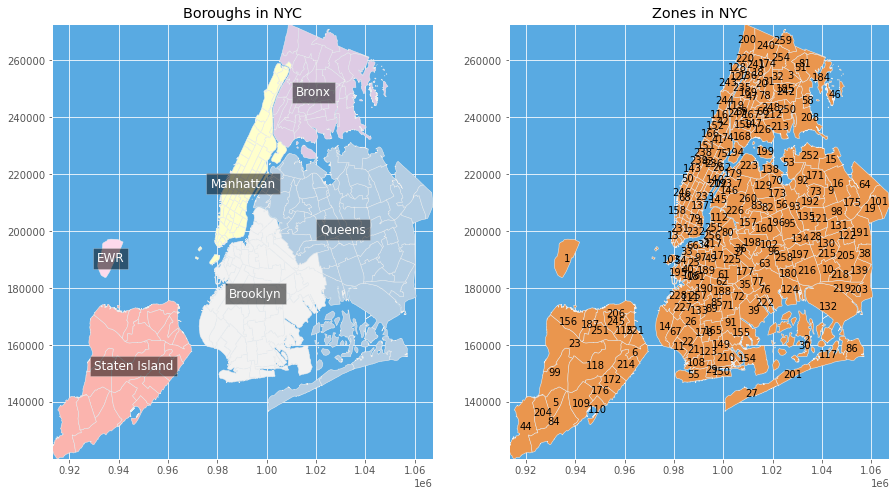

In [22]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,8))
ax = plt.subplot(1, 2, 1)
ax.set_title("Boroughs in NYC")
draw_region_map(ax, sf)
ax = plt.subplot(1, 2, 2)
ax.set_title("Zones in NYC")
draw_zone_map(ax, sf)

### Q1: Which regions have most pickups and drop-offs?

In [15]:
df_pu = pd.read_sql_query('SELECT PULocationID AS LocationID, count(*) AS PUcount \
                        FROM table_record \
                        GROUP BY PULocationID', nyc_database)

df_do = pd.read_sql_query('SELECT DOLocationID AS LocationID, count(*) AS DOcount \
                        FROM table_record \
                        GROUP BY DOLocationID', nyc_database)

In [17]:
template = pd.DataFrame([x for x in range(1,max(df_loc['LocationID'].tolist()))], columns=["LocationID"])
df_q1 = pd.concat([df_pu, df_do]).join(template.set_index("LocationID"), how = 'outer', on=["LocationID"]).fillna(0) \
                                    .groupby(["LocationID"], as_index=False) \
                                    .agg({'PUcount': 'sum', 'DOcount': 'sum'})\
                                    .sort_values(by=['LocationID'])
df_q1['TOTALcount'] = df_q1['PUcount'] + df_q1['DOcount']
loc = df_loc[["LocationID", "zone", "borough"]]
df_q1 = df_q1.merge(loc, left_on="LocationID", right_on="LocationID")

PUcount = dict(zip(df_q1['LocationID'].tolist(), df_q1['PUcount'].tolist()))
PUtop3 = df_q1.sort_values(by=['PUcount'], ascending=False).set_index("LocationID").head(3)
DOcount = dict(zip(df_q1['LocationID'].tolist(), df_q1['DOcount'].tolist()))
DOtop3 = df_q1.sort_values(by=['DOcount'], ascending=False).set_index("LocationID").head(3)

In [18]:
PUtop3

,PUcount,DOcount,TOTALcount,zone,borough
LocationID,,,,,
237,1141989.0,1005927.0,2147916.0,Upper East Side South,Manhattan
236,1090947.0,1117542.0,2208489.0,Upper East Side North,Manhattan
161,1082985.0,1036044.0,2119029.0,Midtown Center,Manhattan


In [19]:
DOtop3

,PUcount,DOcount,TOTALcount,zone,borough
LocationID,,,,,
236,1090947.0,1117542.0,2208489.0,Upper East Side North,Manhattan
161,1082985.0,1036044.0,2119029.0,Midtown Center,Manhattan
237,1141989.0,1005927.0,2147916.0,Upper East Side South,Manhattan


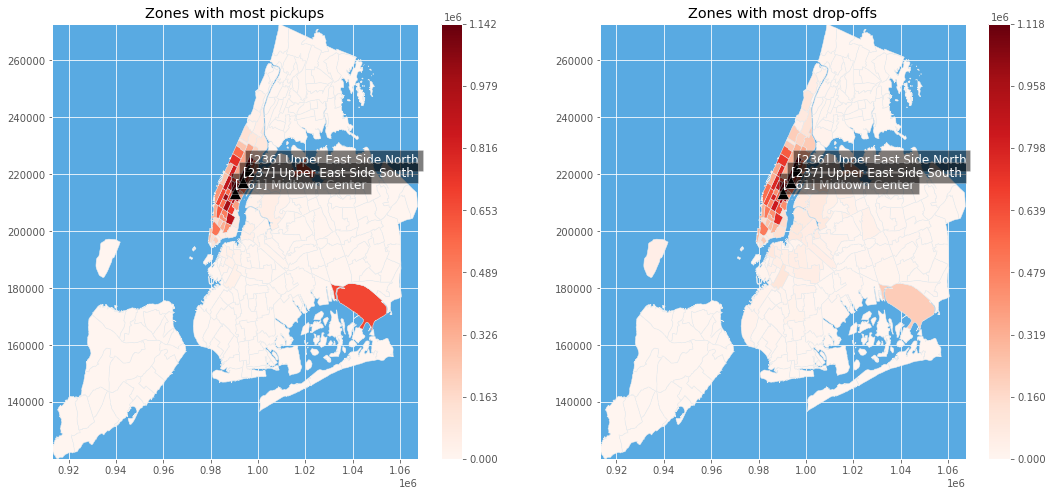

In [23]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18,8))
ax = plt.subplot(1, 2, 1)
ax.set_title("Zones with most pickups")
draw_zone_map(ax, sf, heat=PUcount, text=PUtop3.index.tolist())
ax = plt.subplot(1, 2, 2)
ax.set_title("Zones with most drop-offs")
draw_zone_map(ax, sf, heat=DOcount, text=DOtop3.index.tolist())

In [24]:
df_q1_region = df_q1.groupby(["borough"], as_index=False) \
                    .agg({'PUcount': 'sum', 'DOcount': 'sum', 'TOTALcount': 'sum'}) \
                    .sort_values(by=['TOTALcount'], ascending=False)
df_q1_region

,borough,PUcount,DOcount,TOTALcount
3,Manhattan,26570397.0,25693767.0,52264164.0
4,Queens,1627137.0,1371936.0,2999073.0
1,Brooklyn,400155.0,1342395.0,1742550.0
0,Bronx,23364.0,170019.0,193383.0
2,EWR,2088.0,47457.0,49545.0
5,Staten Island,1362.0,7449.0,8811.0


In [25]:
PUcount = dict(zip(df_q1_region['borough'].tolist(), df_q1_region['PUcount'].tolist()))
DOcount = dict(zip(df_q1_region['borough'].tolist(), df_q1_region['DOcount'].tolist()))

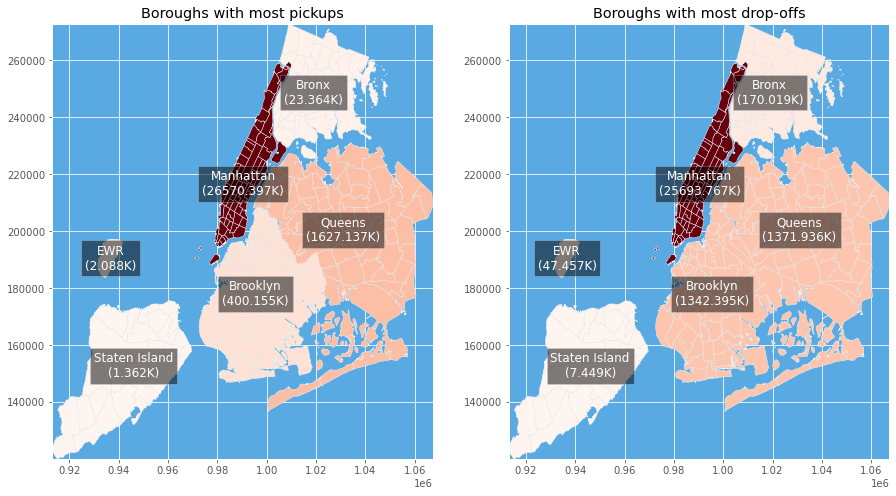

In [26]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,8))
ax = plt.subplot(1, 2, 1)
ax.set_title("Boroughs with most pickups")
draw_region_map(ax, sf, heat = PUcount)
ax = plt.subplot(1, 2, 2)
ax.set_title("Boroughs with most drop-offs")
draw_region_map(ax, sf, heat = DOcount)

### Q2: When are the peak hours and off-peak hours for taking taxi?

In [16]:
df_pu = pd.read_sql_query('SELECT pickup_hour AS time, count(*) AS PUcount \
                        FROM table_record \
                        GROUP BY pickup_hour', nyc_database)
df_do = pd.read_sql_query('SELECT dropoff_hour AS time, count(*) AS DOcount \
                        FROM table_record \
                        GROUP BY dropoff_hour', nyc_database)
df_q2 = df_pu.merge(df_do, on="time")

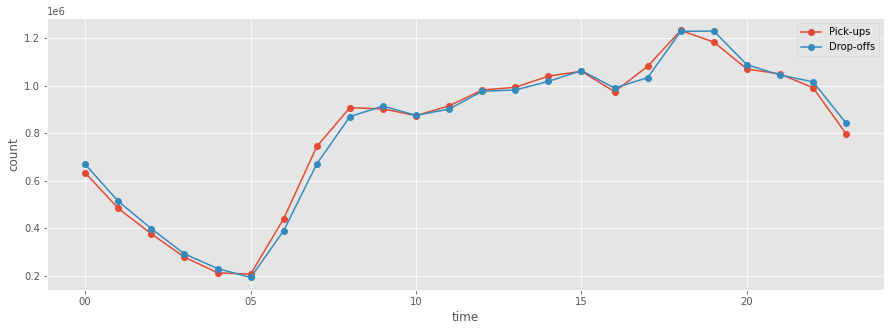

In [17]:
template = pd.DataFrame(["{0:0=2d}".format(x) for x in range(0,24)], columns=["time"])
df_q2 = df_q2.join(template.set_index("time"), how = 'outer', on=["time"]).fillna(0) \
                .groupby(["time"], as_index=False) \
                .agg({'PUcount': 'sum', 'DOcount': 'sum'}) \
                .rename(columns = {'PUcount':'Pick-ups', 'DOcount': 'Drop-offs'}) \
                .sort_values(by='time')

ax = df_q2.plot(x='time', y=['Pick-ups', 'Drop-offs'], kind='line', style="-o", figsize=(15,5))
ax.set_ylabel("count")
plt.show()

### Q3: What are the differences between short and long distance trips of taking taxi?

In [27]:
df_dist = pd.read_sql_query('SELECT trip_distance FROM table_record', nyc_database)
df_dist['trip_distance'].describe()

count    2.913037e+07
mean     2.813899e+00
std      3.611680e+00
min      0.000000e+00
25%      9.500000e-01
50%      1.600000e+00
75%      2.900000e+00
max      2.647100e+02
Name: trip_distance, dtype: float64

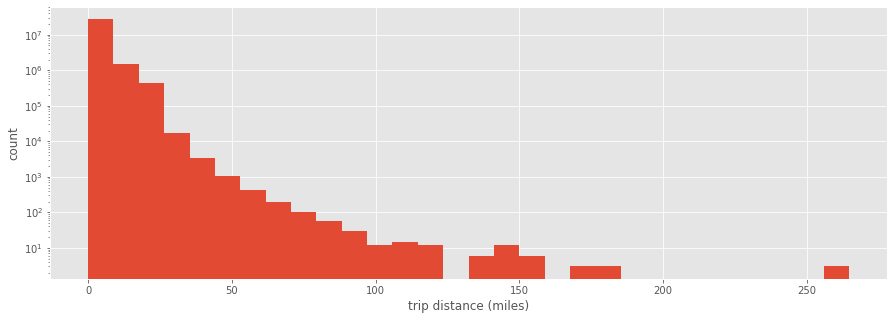

In [28]:
ax = df_dist['trip_distance'].hist(bins=30, figsize=(15,5))
ax.set_yscale('log')
ax.set_xlabel("trip distance (miles)")
ax.set_ylabel("count")
plt.show()

In [29]:
df_q3_short = pd.read_sql_query('SELECT count(*) AS count FROM table_record \
                                 WHERE trip_distance < 30', nyc_database)
df_q3_long = pd.read_sql_query('SELECT count(*) AS count FROM table_record \
                                WHERE trip_distance >= 30 ', nyc_database)
print("Short Trips: {} records in total.\nLong Trips: {} records in total."\
     .format(df_q3_short.values[0][0], df_q3_long.values[0][0]))

Short Trips: 29120121 records in total.
Long Trips: 10251 records in total.


#### Observe The Difference in Temporal Attributes

In [30]:
def diff_short_long_trip_on_time():
    fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(18,18))

    ax = plt.subplot(2,2,1, polar=True)
    # make the histogram that bined on 24 hour
    radii = np.array(df_q3_PU['short trips'].tolist(), dtype="int64")
    title = "Pickup Time for Short Trips"
    plt_clock(ax, radii, title, "#dc143c")

    ax = plt.subplot(2,2,2, polar=True)
    # make the histogram that bined on 24 hour
    radii = np.array(df_q3_PU['long trips'].tolist(), dtype="int64")
    title = "Pickup Time for Long Trips"
    plt_clock(ax, radii, title, "#56B4E9")

    ax = plt.subplot(2,2,3, polar=True)
    # make the histogram that bined on 24 hour
    radii = np.array(df_q3_DO['short trips'].tolist(), dtype="int64")
    title = "Dropoff Time for Short Trips"
    plt_clock(ax, radii, title, "#dc143c")

    ax = plt.subplot(2,2,4, polar=True)
    # make the histogram that bined on 24 hour
    radii = np.array(df_q3_DO['long trips'].tolist(), dtype="int64")
    title = "Dropoff Time for Long Trips"
    plt_clock(ax, radii, title, "#56B4E9")

In [33]:
def diff_short_long_trip_on(attr, rpr="count", kind='bar'):
    df_q3_short = pd.read_sql_query('SELECT '+attr+', count(*) as count \
                                    FROM table_record \
                                    WHERE trip_distance < 30 \
                                    GROUP BY '+attr, nyc_database)
    df_q3_long = pd.read_sql_query('SELECT '+attr+', avg(trip_distance) AS AVG_trip_distance, count(*) as count \
                                    FROM table_record \
                                    WHERE trip_distance >= 30 \
                                    GROUP BY '+attr, nyc_database)
    if rpr == "proportion":
        s = np.sum(df_q3_short['count'].values)
        df_q3_short['proportion'] = [float(x)/s for x in df_q3_short['count']]
        s = np.sum(df_q3_long['count'].values)
        df_q3_long['proportion'] = [float(x)/s for x in df_q3_long['count']]
    
    df_q3 = df_q3_short.merge(df_q3_long, on=attr, suffixes=["_short", "_long"]) \
                        .rename(columns={rpr+"_short":"short trips", rpr+"_long":"long trips"}) 
    ax = df_q3.plot(x=attr, y=['short trips', 'long trips'], kind=kind, figsize=(15,5))
    ax.set_ylabel(rpr)
    ax.set_title(attr.replace("_", " ")+" difference in short/long trip")

In [35]:
def plt_clock(ax, radii, title, color):
    N = 24
    bottom = 2

    # create theta for 24 hours
    theta = np.linspace(0.0, 2 * np.pi, N, endpoint=False)


    # width of each bin on the plot
    width = (2*np.pi) / N
    
    bars = ax.bar(theta, radii, width=width, bottom=bottom, color=color, edgecolor="#999999")

    # set the lable go clockwise and start from the top
    ax.set_theta_zero_location("N")
    # clockwise
    ax.set_theta_direction(-1)

    # set the label
    ax.set_xticks(theta)
    ticks = ["{}:00".format(x) for x in range(24)]
    ax.set_xticklabels(ticks)
    ax.set_title(title)

In [31]:
df_q3_short = pd.read_sql_query('SELECT pickup_hour AS PUtime, \
                                 dropoff_hour AS DOtime, count(*) AS count \
                                 FROM table_record \
                                 WHERE trip_distance < 30 \
                                 GROUP BY pickup_hour, dropoff_hour', nyc_database)
df_q3_long = pd.read_sql_query('SELECT pickup_hour AS PUtime, \
                                 dropoff_hour AS DOtime, count(*) AS count \
                                 FROM table_record \
                                 WHERE trip_distance >= 30 \
                                 GROUP BY pickup_hour, dropoff_hour', nyc_database)

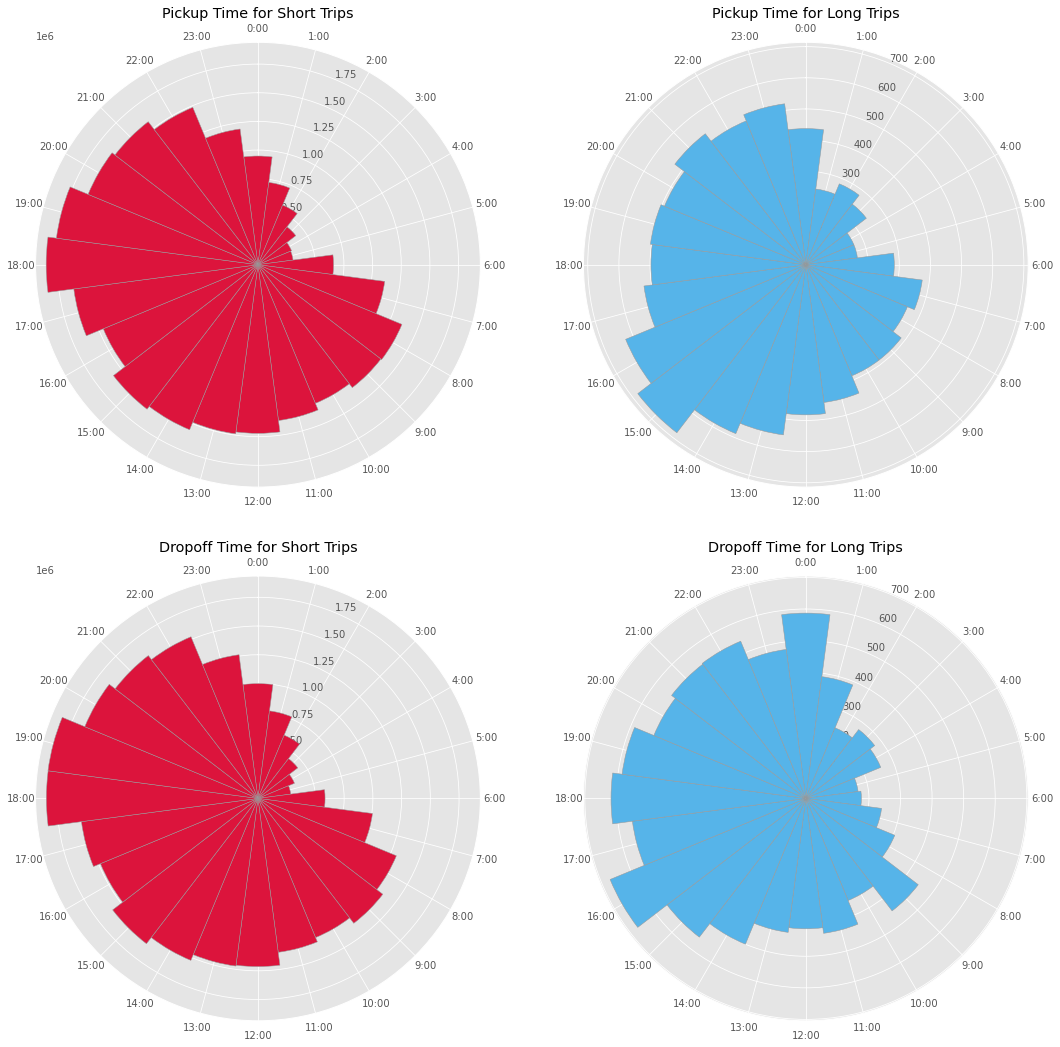

In [36]:
df_q3 = df_q3_short.merge(df_q3_long, on=["PUtime", "DOtime"], suffixes=["_short", "_long"]) \
                        .rename(columns={"count_short":"short trips", "count_long":"long trips", \
                                        "PUtime":"pickup time", "DOtime":"dropoff time"})

df_q3_PU = df_q3.groupby(["pickup time"], as_index=False) \
            .agg({'short trips': 'sum', 'long trips':'sum'}) \
            .sort_values(by="pickup time")
df_q3_DO = df_q3.groupby(["dropoff time"], as_index=False) \
            .agg({'short trips': 'sum', 'long trips':'sum'}) \
            .sort_values(by="dropoff time")

diff_short_long_trip_on_time()

#### Observe The Difference in Spatial Attributes

In [37]:
df_q3_short = pd.read_sql_query('SELECT PULocationID, DOLocationID, count(*) AS count \
                                 FROM table_record \
                                 WHERE trip_distance < 30 \
                                 GROUP BY PULocationID, DOLocationID', nyc_database)
df_q3_long = pd.read_sql_query('SELECT PULocationID, DOLocationID, count(*) AS count \
                                 FROM table_record \
                                 WHERE trip_distance >= 30 \
                                 GROUP BY PULocationID, DOLocationID', nyc_database)

In [38]:
df_q3 = df_q3_short.merge(df_q3_long, on=["PULocationID", "DOLocationID"], suffixes=["_short", "_long"]) \
                        .rename(columns={"count_short":"short trips", "count_long":"long trips"})
df_q3 = df_q3.merge(df_loc[["LocationID", "zone"]], left_on="PULocationID", right_on="LocationID") \
             .drop(['LocationID'], axis=1).rename(columns={"zone":"pickup zone"}) \
             .merge(df_loc[["LocationID", "zone"]], left_on="DOLocationID", right_on="LocationID") \
             .drop(['LocationID'], axis=1).rename(columns={"zone":"dropoff zone"})

In [39]:
ShortTrip_top3 = df_q3.sort_values(by="short trips", ascending=False).head(3)
ShortTrip_top3[['pickup zone', 'dropoff zone', 'short trips']]

,pickup zone,dropoff zone,short trips
387,Upper East Side South,Upper East Side South,125892
188,Upper East Side South,Midtown East,71454
364,Upper West Side South,Upper West Side South,62082


In [40]:
LongTrip_top3 = df_q3.sort_values(by="long trips", ascending=False).head(3)
LongTrip_top3[['pickup zone', 'dropoff zone', 'long trips']]

,pickup zone,dropoff zone,long trips
11,JFK Airport,Newark Airport,786
56,JFK Airport,JFK Airport,315
13,LaGuardia Airport,Newark Airport,231


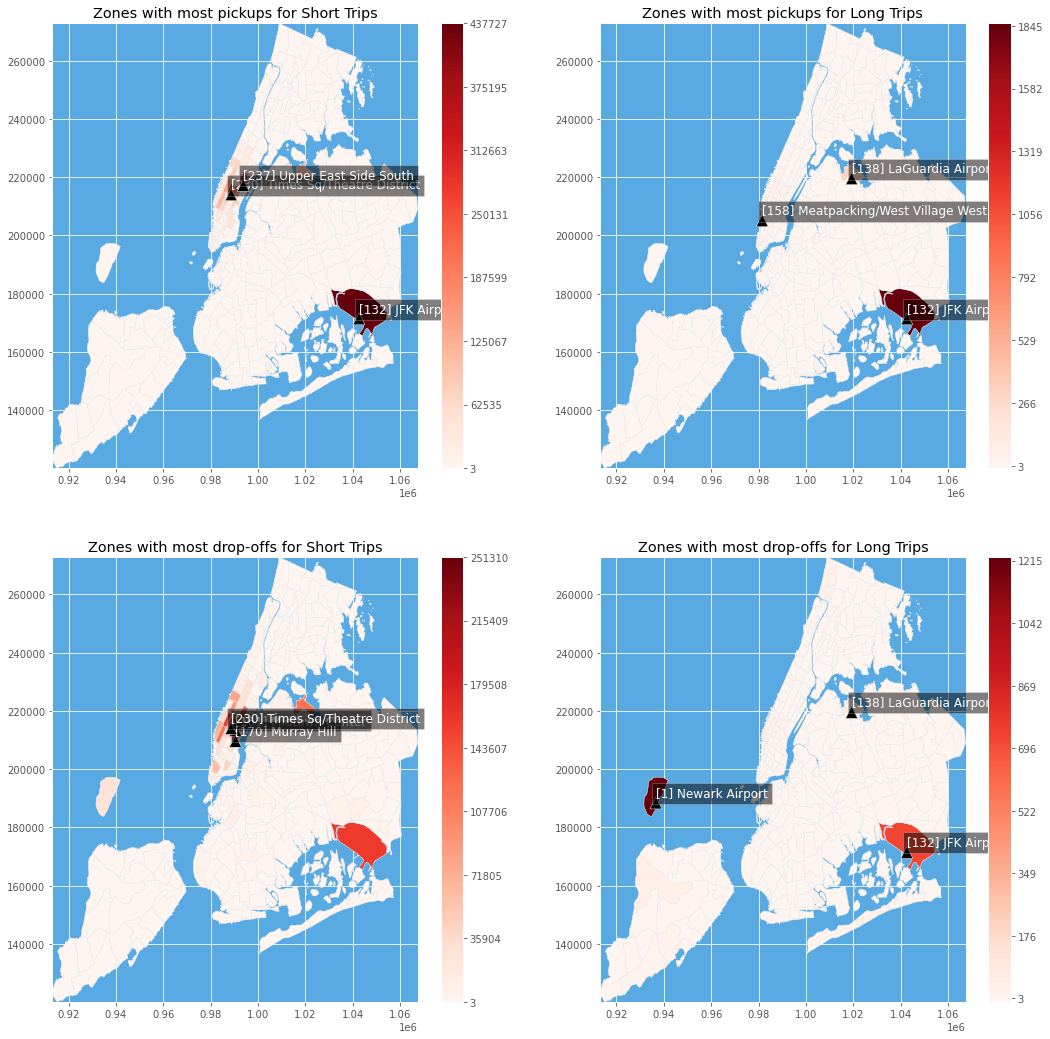

In [41]:
df_q3_PU = df_q3.groupby("PULocationID", as_index=False).agg({'short trips':'sum', 'long trips':'sum'})
PUtop3_short = df_q3_PU.sort_values(by=['short trips'], ascending=False).set_index("PULocationID").head(3)
PUtop3_long = df_q3_PU.sort_values(by=['long trips'], ascending=False).set_index("PULocationID").head(3)
PUcount_short = dict(zip(df_q3_PU['PULocationID'].tolist(), df_q3_PU['short trips'].tolist()))
PUcount_long = dict(zip(df_q3_PU['PULocationID'].tolist(), df_q3_PU['long trips'].tolist()))

df_q3_DO = df_q3.groupby("DOLocationID", as_index=False).agg({'short trips':'sum', 'long trips':'sum'})
DOtop3_short = df_q3_DO.sort_values(by=['short trips'], ascending=False).set_index("DOLocationID").head(3)
DOtop3_long = df_q3_DO.sort_values(by=['long trips'], ascending=False).set_index("DOLocationID").head(3)
DOcount_short = dict(zip(df_q3_DO['DOLocationID'].tolist(), df_q3_DO['short trips'].tolist()))
DOcount_long = dict(zip(df_q3_DO['DOLocationID'].tolist(), df_q3_DO['long trips'].tolist()))

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(18,18))
ax = plt.subplot(2, 2, 1)
ax.set_title("Zones with most pickups for Short Trips")
draw_zone_map(ax, sf, heat=PUcount_short, text=PUtop3_short.index.tolist())
ax = plt.subplot(2, 2, 2)
ax.set_title("Zones with most pickups for Long Trips")
draw_zone_map(ax, sf, heat=PUcount_long, text=PUtop3_long.index.tolist())
ax = plt.subplot(2, 2, 3)
ax.set_title("Zones with most drop-offs for Short Trips")
draw_zone_map(ax, sf, heat=DOcount_short, text=DOtop3_short.index.tolist())
ax = plt.subplot(2, 2, 4)
ax.set_title("Zones with most drop-offs for Long Trips")
draw_zone_map(ax, sf, heat=DOcount_long, text=DOtop3_long.index.tolist())

#### Other Differences

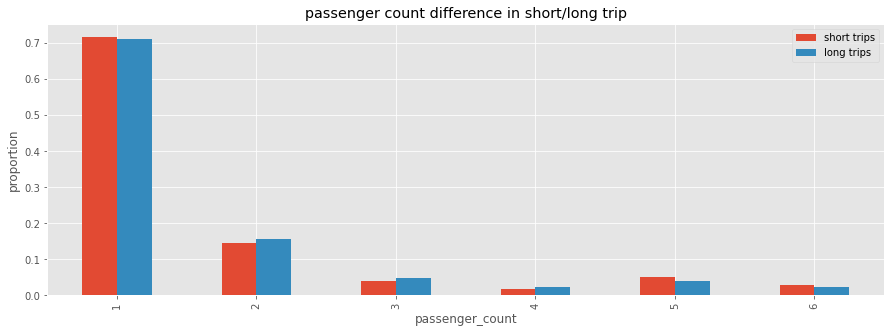

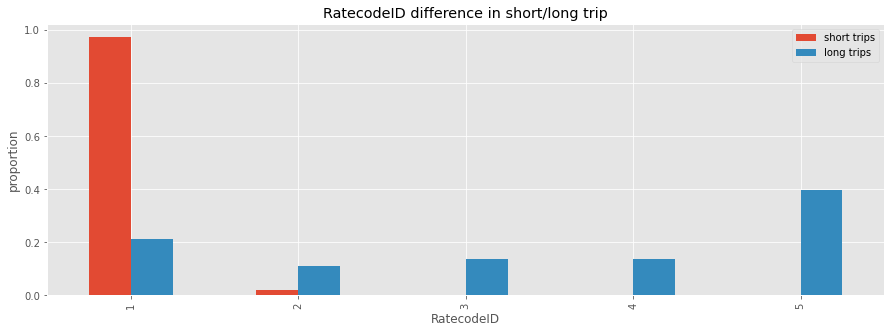

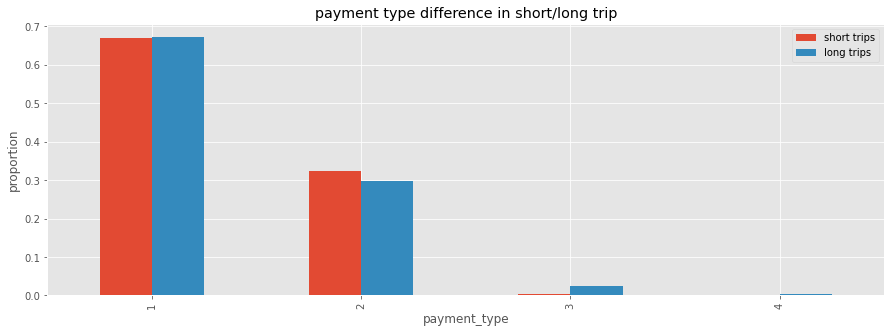

In [42]:
for attr in ["passenger_count", "RatecodeID", "payment_type"]:
    diff_short_long_trip_on(attr, rpr="proportion", kind='bar')